In [1]:
import pandas as pd
from math import log
import operator

In [2]:
#计算熵，即信息的期望值
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts.keys():
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2)
    return shannonEnt

In [3]:
def createDataSet():
    dataSet = [[1,1,'yes'],
              [1,1,'yes'],
              [1,0,'no'],
              [0,1,'no'],
              [0,1,'no']]
    labels = ['no surfacing','flippers']
    return dataSet,labels

In [4]:
myDat,labels = createDataSet()

In [5]:
##划分数据集
def splitDataSet(dataSet,axis,value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [6]:
##选择最佳的划分特征
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet,i,value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [7]:
##投票法确定叶子节点的类别
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

In [8]:
##创建决策树
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree

In [9]:
createTree(myDat,labels)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [10]:
##3.2.1 绘制树节点
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle = 'sawtooth', fc = '0.8')
leafNode = dict(boxstyle = 'round4',fc='0.8')
arrow_args = dict(arrowstyle = '<-')

def plotNode(nodeTxt,centerPt, parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',
                          va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)
# def createPlot():
#     fig = plt.figure(1,facecolor='white')
#     fig.clf()
#     createPlot.ax1 = plt.subplot(111,frameon=False)
#     plotNode('a decision node',(0.5,0.1),(0.1,0.5),decisionNode)
#     plotNode('a leaf node',(0.8,0.1),(0.3,0.8),leafNode)
#     plt.show()

In [11]:
createPlot()

NameError: name 'createPlot' is not defined

In [12]:
##3.2.2构造注解树

###获取叶节点的数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

###获取树的深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
            
    return maxDepth

In [13]:
##测试树，方式存储
def retrieveTree(i):
    listofTrees = [{'no surfacing':{0:'no',1:{'flippers':
                                             {0:'no',1:'yes'}}}},
                  {'no surfacing':{0:'no',1:{'flippers':
                                            {0:{'head':{0:'no',1:'yes'}},1:'no'}}}}
                  ]
    return listofTrees[i]

In [14]:
myTree = retrieveTree(0)

In [15]:
def plotMidText(cntrPt,parentPt,txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)
    
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree)[0]
    cntrPt = (plotTree.xoff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,
             plotTree.yoff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    
    secondDict = myTree[firstStr]
    plotTree.yoff = plotTree.yoff - 1.0/plotTree.totalD
    
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xoff = plotTree.xoff + 1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xoff,plotTree.yoff),cntrPt,leafNode)
            plotMidText((plotTree.xoff,plotTree.yoff),cntrPt,str(key))
    plotTree.yoff = plotTree.yoff + 1.0/plotTree.totalD

In [16]:
def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xoff = -0.5/plotTree.totalW
    plotTree.yoff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

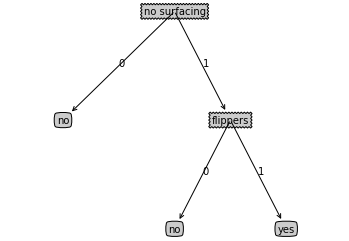

In [17]:
createPlot(myTree)

In [ ]:
##3.3.1 测试算法

In [30]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree)[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)  #列表的下标
    
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key],featLabels,testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [23]:
myDat,labels = createDataSet()

In [25]:
myTree = retrieveTree(0)

In [31]:
###测试1
classify(myTree,labels,[1,0])

'no'

In [40]:
###测试2
classify(myTree,labels,[1,1])

'yes'

In [48]:
##3.3.2 决策树存储
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename,'rb')
    return pickle.load(fr)

In [49]:
storeTree(myTree,'classifierStorage.txt')

In [50]:
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [ ]:
##3.4 使用决策树预测隐形眼镜类型

In [75]:
from pathlib import Path
data_path=Path('D:\\python_algorithm\\machinelearinginaction\\《机器学习实战》Python3代码\\Ch03')

fr = open(data_path / 'lenses.txt')

In [73]:
lenses = [line.strip().split('\t')  for line in fr.readlines()]

In [79]:
lensesLabels = ['age','prescript','astigmatic','tearRate']

In [81]:
lensesTree = createTree(lenses,lensesLabels)

In [82]:
lensesTree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}}}},
    'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}},
      'young': 'soft'}}}}}}

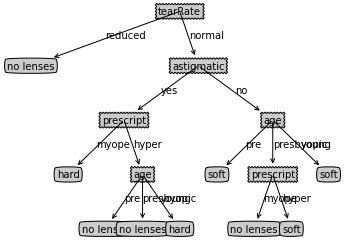

In [83]:
createPlot(lensesTree)